In [12]:
import pandas as pd
import os
import numpy as np
import cvxpy as cp
from math import sqrt
from scipy import stats

In [32]:
# Создаются датафреймы с данными по активам трёх компаний за последние 100 недель
path1 = 'https://raw.githubusercontent.com/Vladimir-Nikolaev-HSE/Project/master/YNDX.csv'
df1 = pd.read_csv(path1)

path2 = 'https://raw.githubusercontent.com/Vladimir-Nikolaev-HSE/Project/master/SFOR.L.csv'
df2 = pd.read_csv(path2)

path3 = 'https://raw.githubusercontent.com/Vladimir-Nikolaev-HSE/Project/master/PSON.L.csv'
df3 = pd.read_csv(path3)

In [52]:
# Функция, вычисляющая доходности и добавляющая столбец с получившимися значениями
def calc_profitability(df):
    df["Profit"] = df.sort_values("Date")["Open"].diff().div(df["Open"].shift(1))*100

In [53]:
calc_profitability(df1)
calc_profitability(df2)
calc_profitability(df3)

In [83]:
profit11 = df1["Profit"].dropna()
profit22 = df2["Profit"].dropna()
profit33 = df3["Profit"].dropna()

In [85]:
# Создаётся матрица с доходностями
data = np.vstack((profit11, profit22, profit33))

In [116]:
# Оценка вектора мат. ожиданий доходностей
m1 = profit11.mean()
m2 = profit22.mean()
m3 = profit33.mean()
m = np.array([m1, m2, m3])
print(m)

[0.71676742 1.34934477 0.07847645]


In [139]:
# Оценка ковариационной матрицы
C = np.cov(data)
print(C)

[[26.63077322 10.64949783  7.87867141]
 [10.64949783 37.78906199  2.94902004]
 [ 7.87867141  2.94902004 25.87832895]]


In [140]:
# Разложение Халецкого для ковариационной матрицы
R = np.linalg.cholesky(C)
print(R)

[[ 5.16050126  0.          0.        ]
 [ 2.0636557   5.79054291  0.        ]
 [ 1.52672599 -0.03481828  4.8524452 ]]


In [141]:
# Находятся коэффициенты корреляции Пирсона и соответствующие p-значения
print('Для компаний 1 и 2:', np.around(stats.pearsonr(profit11, profit22), 3))
print('Для компаний 1 и 3:', np.around(stats.pearsonr(profit11, profit33), 3))
print('Для компаний 3 и 2:', np.around(stats.pearsonr(profit33, profit22), 3))

Для компаний 1 и 2: [0.336 0.001]
Для компаний 1 и 3: [0.3   0.002]
Для компаний 3 и 2: [0.094 0.351]


In [148]:
# Решение задачи с функцией полезности инвестора
n = 3 # количество активов
a = cp.Variable(n) # векторная переменная для портфеля
teta = input() # ввод коэффициента осторожности инвестора
ret = a @ m.T # функция дохожности
risk = cp.norm(R.T @ a) # функция риска
prob = cp.Problem(cp.Maximize(ret - teta * risk), [#a >= 0, # при запрете коротких продаж
    cp.sum(a) == 1]) # поиск максимума целевой функции при сумме долей = 1
prob.solve()
print('\nЗначение целевой функции: ', np.around(prob.value, 3),'\n', sep='')
print('Значения долей активов в портфеле:', np.around(a.value, 3))

0.4

Значение целевой функции: -0.771

Значения долей активов в портфеле: [0.338 0.476 0.186]


Значение тета: 0.2
Значение целевой функции: 0.193
Значения долей активов: [ 0.408  0.982 -0.39 ] 

Значение тета: 0.4
Значение целевой функции: -0.771
Значения долей активов: [0.338 0.476 0.186] 

Значение тета: 0.6
Значение целевой функции: -1.579
Значения долей активов: [0.327 0.396 0.277] 

Значение тета: 0.8
Значение целевой функции: -2.36
Значения долей активов: [0.322 0.36  0.318] 

Значение тета: 1
Значение целевой функции: -3.132
Значения долей активов: [0.319 0.34  0.341] 



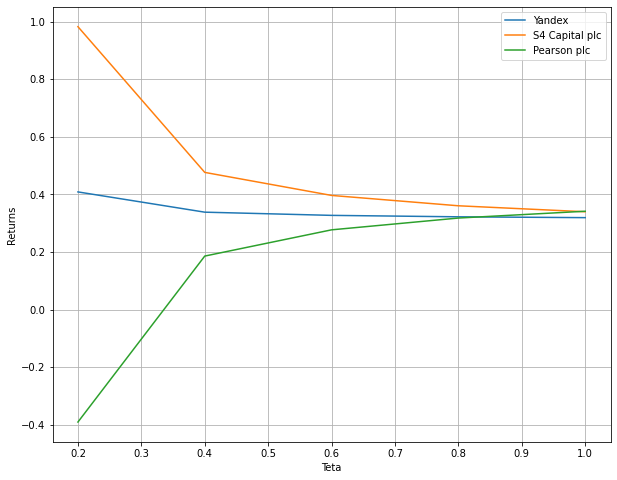

In [108]:
# Поиск значений портфеля и целевой функции при различных тета
# Построение графика зависимости долей активов в портфеля в зависимости от кф тета
import matplotlib.pyplot as plt
tetas = [0.2, 0.4, 0.6, 0.8, 1]
data1 = []
data2 = []
data3 = []
for i in tetas:
    prob = cp.Problem(cp.Maximize(ret - i * risk), [#a >= 0, # при запрете коротких продаж
        cp.sum(a) == 1])
    prob.solve()
    print('Значение тета:', i)
    print('Значение целевой функции:', np.around(prob.value, 3))
    print('Значения долей активов:', np.around(a.value, 3), '\n')
    data1.append(a.value[0])
    data2.append(a.value[1])
    data3.append(a.value[2])
    
plt.figure(figsize=(10, 8))
plt.plot(tetas, data1, label='Yandex')
plt.plot(tetas, data2, label='S4 Capital plc')
plt.plot(tetas, data3, label='Pearson plc')

plt.legend()
plt.grid(True)
plt.xlabel("Teta")
plt.ylabel("Returns")
plt.show()

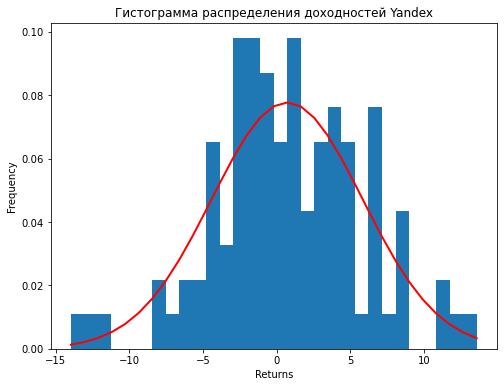

In [117]:
# Гистограмма распределения доходностей для актива 1
mu, sigma = m1, np.std(profit11)
plt.figure(figsize=(8, 6))
count, bins, ignored = plt.hist(profit11, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.title('Гистограмма распределения доходностей Yandex')
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.show()

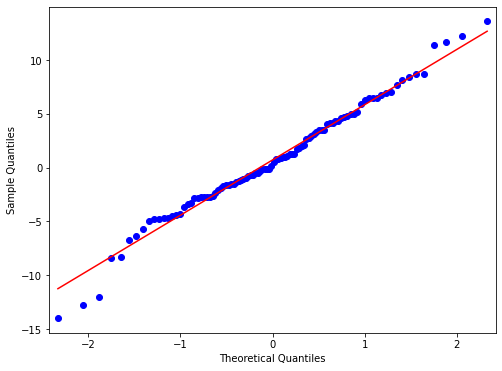

In [128]:
# QQ-график для доходностей актива 1
import statsmodels.api as sm
import pylab
sm.qqplot(profit11, line='s')
pylab.rcParams['figure.figsize'] = 8, 6
pylab.show()

In [131]:
# Тест Jarque-Bera для доходностей актива 1
JB, p_value = stats.jarque_bera(profit11)
print('JB =', JB, '\np-value =', p_value)

JB = 0.8968398175122934 
p-value = 0.6386364586797763


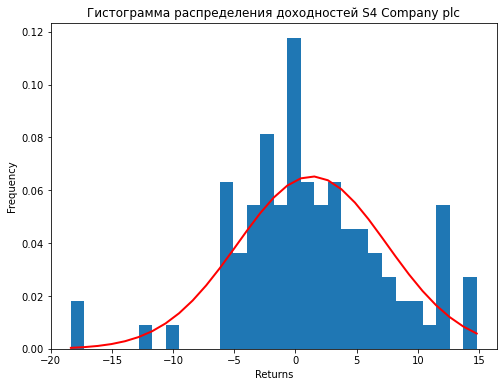

In [119]:
# Гистограмма распределения доходностей для актива 2
mu, sigma = m2, np.std(profit22)
plt.figure(figsize=(8, 6))
count, bins, ignored = plt.hist(profit22, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.title('Гистограмма распределения доходностей S4 Company plc')
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.show()

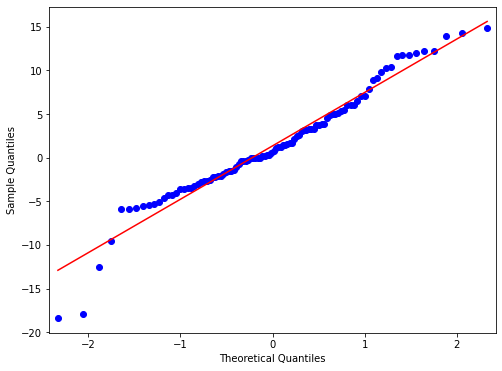

In [129]:
# QQ-график для доходностей актива 2
sm.qqplot(profit22, line='s')
pylab.rcParams['figure.figsize'] = 8, 6
pylab.show()

In [132]:
# Тест Jarque-Bera для доходностей актива 2
JB, p_value = stats.jarque_bera(profit22)
print('JB =', JB, '\np-value =', p_value)

JB = 4.818008367629129 
p-value = 0.08990477864373103


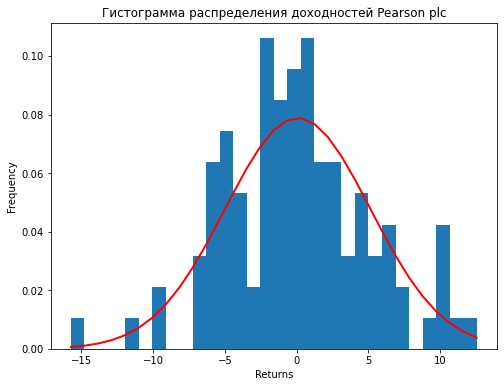

In [120]:
# Гистограмма распределения доходностей для актива 3
mu, sigma = m3, np.std(profit33)
plt.figure(figsize=(8, 6))
count, bins, ignored = plt.hist(profit33, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.title('Гистограмма распределения доходностей Pearson plc')
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.show()

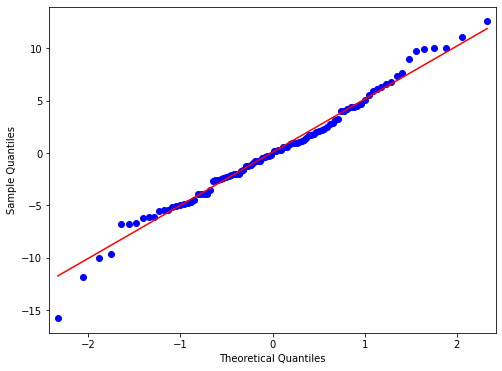

In [130]:
# QQ-график для доходностей актива 3
sm.qqplot(profit33, line='s')
pylab.rcParams['figure.figsize'] = 8, 6
pylab.show()

In [133]:
# Тест Jarque-Bera для доходностей актива 3
JB, p_value = stats.jarque_bera(profit33)
print('JB =', JB, '\np-value =', p_value)

JB = 0.6149065123965359 
p-value = 0.7353172382676809


In [157]:
# Решение задачи с ограничением типа VaR
n = 3 # количество рисковых активов
a1 = cp.Variable(n) # переменный вектор портфеля
alpha = float(input()) # вводим alpha
beta = float(input()) # вводим beta
z_beta = stats.norm.ppf(beta) # вычисляем z_beta
m0 = float(input()) # вводим доходность безрискового актива за неделю
m00 = np.array([m0, m0, m0])
m_del = m - m00 # вычисляется m delta
ret1 = a1 @ m_del.T # задаётся целевая функция
sigma = cp.norm(R.T @ a1) # задаётся сигма
# находится максимум целевой функции с ограничением
prob = cp.Problem(cp.Maximize(ret1), [#a1 >= 0, # при запрете коротких продаж
                                      1/z_beta * ret1 - sigma >= 1/z_beta * (alpha - m0)])
prob.solve()
print('\nЗначение целевой функции:', prob.value,'\n')
aa1 = a1.value
a4 = 1 - (aa1[0] + aa1[1] + aa1[2])
print('Доли рисковых активов в портфеле:', a1.value)
print('\nДоля безрискового актива в портфеле:', a4)

-1
0.9
0

Значение целевой функции: 0.22063668061642439 

Доли рисковых активов в портфеле: [ 0.06517802  0.1301833  -0.02220996]

Доля безрискового актива в портфеле: 0.826848636650509


beta = 0.85
Значение целевой функции: 0.288
Доли рисковых активов: [ 0.085  0.17  -0.029]
Доля безрискового актива: 0.774 

beta = 0.87
Значение целевой функции: 0.259
Доли рисковых активов: [ 0.076  0.153 -0.026]
Доля безрискового актива: 0.797 

beta = 0.89
Значение целевой функции: 0.233
Доли рисковых активов: [ 0.069  0.137 -0.023]
Доля безрискового актива: 0.817 

beta = 0.91
Значение целевой функции: 0.209
Доли рисковых активов: [ 0.062  0.123 -0.021]
Доля безрискового актива: 0.836 

beta = 0.93
Значение целевой функции: 0.186
Доли рисковых активов: [ 0.055  0.11  -0.019]
Доля безрискового актива: 0.854 

beta = 0.9500000000000001
Значение целевой функции: 0.164
Доли рисковых активов: [ 0.048  0.097 -0.017]
Доля безрискового актива: 0.871 



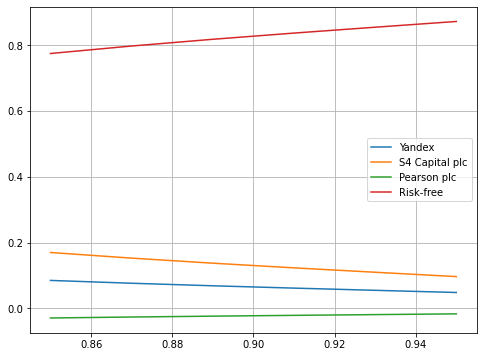

In [178]:
# Поиск значений портфеля и целевой функции при различных beta
# Построение графика зависимости долей активов в портфеля в зависимости от beta
betas = 0.85
data11 = []
data22 = []
data33 = []
riskfree = []
alpha1 = -1
betass = []
m01 = 0
for i in range(6):
    print('beta =', betas)
    z_beta1 = stats.norm.ppf(betas)
    prob = cp.Problem(cp.Maximize(ret1), [#a1 >= 0,
                                      1/z_beta1 * ret1 - sigma >= 1/z_beta1 * (alpha1 - m01)])
    betass.append(betas)
    prob.solve()
    data11.append(a1.value[0])
    data22.append(a1.value[1])
    data33.append(a1.value[2])
    aa1 = a1.value
    a4 = 1 - (aa1[0] + aa1[1] + aa1[2])
    riskfree.append(a4)
    betas += 0.02
    print('Значение целевой функции:', np.around(prob.value, 3))
    print('Доли рисковых активов:', np.around(a1.value, 3))
    print('Доля безрискового актива:', np.around(a4, 3), '\n')
plt.figure(figsize=(8, 6))
plt.plot(betass, data11, label='Yandex')
plt.plot(betass, data22, label='S4 Capital plc')
plt.plot(betass, data33, label='Pearson plc')
plt.plot(betass, riskfree, label='Risk-free')
plt.legend()
plt.grid(True)

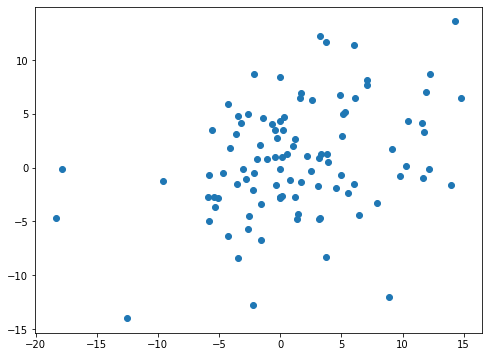

In [181]:
x = profit22
y = profit11
plt.plot(x, y,'o')
plt.show()